In [1]:
import os 
os.chdir('C:\Roman\HDSP_Activities\colibri-hdsp')
print("Current Working Directory " , os.getcwd())

Current Working Directory  C:\Roman\HDSP_Activities\colibri-hdsp


Demo CASSI Reconstruction

In [2]:
#General imports
import matplotlib.pyplot as plt
import torch
import os

manual_device = "cpu"
# Check GPU support
print("GPU support: ", torch.cuda.is_available())

if manual_device:
    device = manual_device
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU support:  True


Load Dataset

In [3]:
from colibri_hdsp.data.datasets import Dataset

# Load dataset

dataset_path = 'cifar10'
keys = ''
batch_size = 128

dataset = Dataset(dataset_path, keys, batch_size)

Loading dataset:  cifar10
Files already downloaded and verified
Files already downloaded and verified


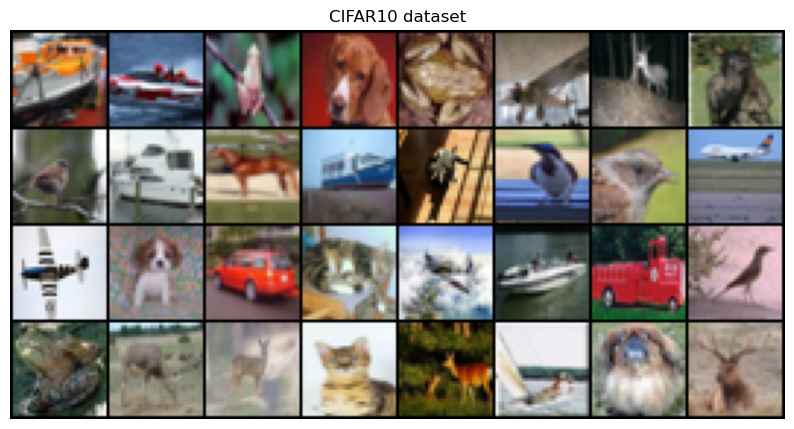

In [4]:
# import make_grid from torchvision
from torchvision.utils import make_grid

sample = next(iter(dataset.train_dataset))[0]

img = make_grid(sample[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')
plt.show()

Optics Layer

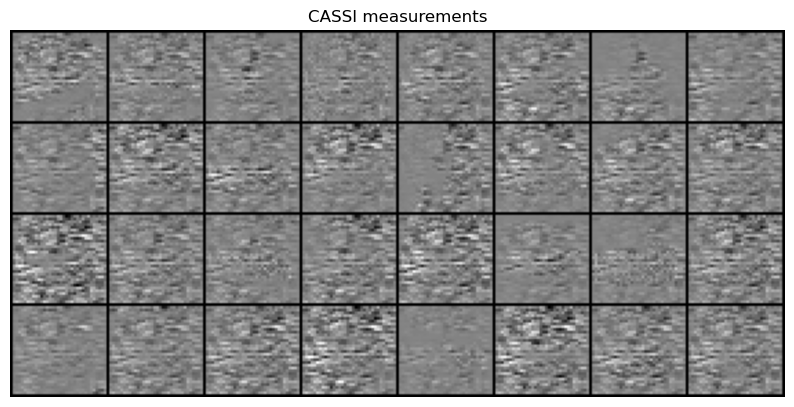

In [5]:
from colibri_hdsp.optics.cassi import CASSI

mode = 'base' # Type of CASSi optical system
cassi =  CASSI(sample.shape[1:], mode,  trainable=True) # CASSI layer
y = cassi(sample) # CASSI measurements

img = make_grid(y[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)


plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title('CASSI measurements')
plt.show()

Build Model

In [7]:
from colibri_hdsp.models import build_network, Unet
from colibri_hdsp.archs import E2E
from colibri_hdsp.train import Training
from colibri_hdsp.metrics import psnr, ssim
from colibri_hdsp.regularizers import Reg_Binary, Reg_Transmittance, MinVariance, KLGaussian
recovery_model = build_network(Unet, in_channels=cassi.L, out_channels=cassi.L)

model = E2E(cassi, recovery_model)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = {"MSE": torch.nn.MSELoss(), "L1": torch.nn.L1Loss()}
metrics = {"PSNR": psnr, "SSIM": ssim}
losses_weights = [1.0, 1.0]

n_epochs = 10
steps_per_epoch = 10
frequency = 1
regularizers_optics_ce = {'binary_reg': Reg_Binary(), 'reg_transmittance': Reg_Transmittance()}
regularizers_optics_ce_weights = [1e-3, 1e-3]

regularizers_optics_mo = {'min_variance': MinVariance()}
regularizers_optics_mo_weights = [1e-3]

train_schedule = Training(model = model, train_loader = dataset.train_dataset, 
                    optimizer = optimizer, loss_func = losses, losses_weights = losses_weights, metrics = metrics, regularizers = None, 
                    regularization_weights = None, schedulers = [], callbacks = [], device = device, regularizers_optics_ce=regularizers_optics_ce, 
                    regularization_optics_weights_ce=regularizers_optics_ce_weights, regularizers_optics_mo=regularizers_optics_mo, 
                    regularization_optics_weights_mo=regularizers_optics_mo_weights)


results = train_schedule.fit(n_epochs=n_epochs, steps_per_epoch=steps_per_epoch, freq=frequency)


Epoch 1/10
  batch 1/391, MSE: 6.732E-02, L1: 2.113E-01, , PSNR: 1.090E+01, SSIM: 6.245E-02, , min_variance: 1.373E-02, , binary_reg: 4.270E+01, reg_transmittance: 6.410E-03, , time per batch: 0.7 [s]
  batch 2/391, MSE: 4.464E-02, L1: 1.731E-01, , PSNR: 1.194E+01, SSIM: 1.678E-01, , min_variance: 1.349E-02, , binary_reg: 4.261E+01, reg_transmittance: 6.405E-03, , time per batch: 0.7 [s]
  batch 3/391, MSE: 3.789E-02, L1: 1.558E-01, , PSNR: 1.183E+01, SSIM: 2.263E-01, , min_variance: 1.338E-02, , binary_reg: 4.253E+01, reg_transmittance: 6.399E-03, , time per batch: 0.7 [s]
  batch 4/391, MSE: 3.467E-02, L1: 1.505E-01, , PSNR: 1.237E+01, SSIM: 2.714E-01, , min_variance: 1.415E-02, , binary_reg: 4.244E+01, reg_transmittance: 6.394E-03, , time per batch: 0.7 [s]
  batch 5/391, MSE: 3.074E-02, L1: 1.404E-01, , PSNR: 1.325E+01, SSIM: 2.910E-01, , min_variance: 1.416E-02, , binary_reg: 4.236E+01, reg_transmittance: 6.389E-03, , time per batch: 0.7 [s]
  batch 6/391, MSE: 2.771E-02, L1: 1.30

Training Loop

## This is commented out because I want to propose to plot metrics in callback!

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# group = batch_size // 3

# loss_df = pd.DataFrame(history["loss"])
# loss_df["batch"] = ( loss_df.index / loss_df.index.max() ) * ( len(loss_df) / group )
# loss_df["batch"] = loss_df["batch"].astype(int)

# psnr_df = pd.DataFrame(history["psnr"])
# psnr_df["batch"] = ( psnr_df.index / psnr_df.index.max() ) * ( len(psnr_df) / group )
# psnr_df["batch"] = psnr_df["batch"].astype(int)

# ssim_df = pd.DataFrame(history["ssim"])
# ssim_df["batch"] = ( ssim_df.index / ssim_df.index.max() ) * ( len(ssim_df) / group )
# ssim_df["batch"] = ssim_df["batch"].astype(int)

# plt.figure(figsize=(13, 2.5))

# plt.subplot(1, 3, 1)
# sns.lineplot(data=loss_df, x="batch", y=0, color="blue")
# plt.ylabel("")
# plt.title("Training Loss")

# plt.subplot(1, 3, 2)
# sns.lineplot(data=psnr_df, x="batch", y=0, color="green")
# plt.ylabel("")
# plt.title("PSNR")

# plt.subplot(1, 3, 3)
# sns.lineplot(data=ssim_df, x="batch", y=0, color="red")
# plt.ylabel("")
# plt.title("SSIM")

# plt.show()



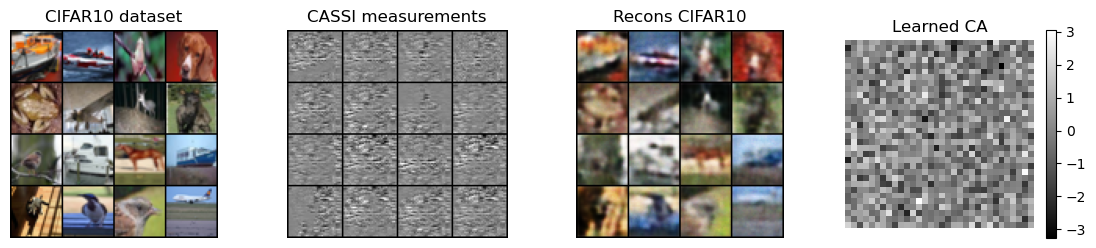

In [8]:
x_est = model(sample.to(device)).cpu()
y_cassi = cassi(sample.to(device)).cpu()

img      = make_grid(sample[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_est  = make_grid(x_est[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_casi = make_grid(y_cassi[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

imgs_dict = {
    "CIFAR10 dataset": img, 
    "CASSI measurements": img_casi,
    "Recons CIFAR10": img_est
}

plt.figure(figsize=(14, 2.7))

for i, (title, img) in enumerate(imgs_dict.items()):
    plt.subplot(1, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

ca = cassi.ca.cpu().detach().numpy().squeeze()

plt.subplot(1, 4, 4)
plt.imshow(ca, cmap='gray')
plt.axis('off')
plt.title('Learned CA')
plt.colorbar()

plt.show()